<a href="https://colab.research.google.com/github/rahul-jha98/zomato_sales_visualizer/blob/master/RestaurantRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!unzip '/content/restaurant-data-with-consumer-ratings.zip'

Archive:  /content/restaurant-data-with-consumer-ratings.zip
  inflating: README                  
  inflating: chefmozaccepts.csv      
  inflating: chefmozcuisine.csv      
  inflating: chefmozhours4.csv       
  inflating: chefmozparking.csv      
  inflating: geoplaces2.csv          
  inflating: rating_final.csv        
  inflating: usercuisine.csv         
  inflating: userpayment.csv         
  inflating: userprofile.csv         


In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from fastai.collab import *

In [0]:
ratings = pd.read_csv('/content/rating_final.csv')
users = pd.read_csv('/content/usercuisine.csv')
places = pd.read_csv('/content/geoplaces2.csv')

In [24]:
ratings.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [25]:
users.head()

,userID,Rcuisine
0,U1001,American
1,U1002,Mexican
2,U1003,Mexican
3,U1004,Bakery
4,U1004,Breakfast-Brunch


In [26]:
places.head()

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,?,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,78280,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rinc�n de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,78000,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,?,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,?,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none


In [27]:
ratings.shape

(1161, 5)

In [0]:
n_users=int(ratings.userID.nunique())
n_place=int(ratings.placeID.nunique())

In [29]:
print("n_users = ",n_users, "||", "n_restaurants = ", n_place )

n_users =  138 || n_restaurants =  130


In [0]:
g = ratings.groupby('userID')['rating'].count()
topg = g.sort_values(ascending = False)[:15]

i = ratings.groupby('placeID')['rating'].count()
topi = i.sort_values(ascending = False)[:15]

In [31]:
join1 = ratings.join(topg, on='userID', how = 'inner', rsuffix='_r')
join1 = join1.join(topi, on='placeID', how = 'inner', rsuffix = '_r')

pd.crosstab(join1.userID, join1.placeID, join1.rating, aggfunc=np.sum)

placeID,132825,132834,132862,132921,135032,135038,135041,135042,135052,135058,135060,135062,135064,135079,135085
userID,,,,,,,,,,,,,,,
U1003,2.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2.0,NaN
U1016,NaN,2.0,2.0,NaN,2.0,NaN,NaN,1.0,2.0,NaN,2.0,2.0,NaN,NaN,2.0
U1022,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,2.0,NaN,1.0,1.0,NaN,NaN,NaN
U1024,1.0,1.0,NaN,NaN,2.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
U1053,1.0,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN
U1061,1.0,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
U1071,2.0,1.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN
U1075,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
U1089,NaN,1.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,0.0,1.0


**NN Embedding Collabrative Filtering**

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='userID', item_name='placeID', rating_name='rating')

In [33]:
data.show_batch()

userID,placeID,target
U1136,135028,2.0
U1112,132834,1.0
U1034,132884,0.0
U1125,135066,1.0
U1087,132663,1.0


In [34]:
ratings.rating.min(), ratings.rating.max()

(0, 2)

In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'userID': 40, 'placeID':40}, layers=[256, 128], y_range=(1, 2))

epoch,train_loss,valid_loss,time
0,0.704328,#na#,00:00
1,0.698908,#na#,00:00
2,0.687950,#na#,00:00
3,0.625377,#na#,00:00
4,0.573267,#na#,00:00
5,0.555199,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


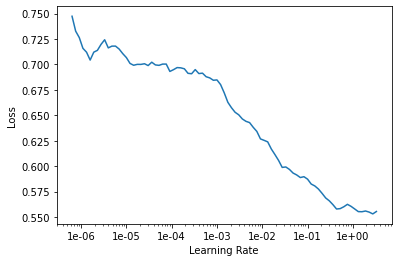

In [39]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [41]:
learn.fit_one_cycle(10, 0.1)

epoch,train_loss,valid_loss,time
0,0.468493,0.467037,00:00
1,0.473100,0.474346,00:00
2,0.467209,0.509645,00:00
3,0.475337,0.531437,00:00
4,0.480036,0.477193,00:00
5,0.477491,0.478620,00:00
6,0.469933,0.472157,00:00
7,0.458370,0.437950,00:00
8,0.447244,0.444313,00:00
9,0.437243,0.446256,00:00
